#  Import necessary libraries

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, make_scorer
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
## pip install pandas scikit-learn nltk transformers torch

# Import dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Print raw data

In [ ]:
path = "/content/drive/MyDrive"
raw_data = pd.read_csv(path + "/train.csv", delimiter=',')

(raw_data)

,abstract_id,line_id,abstract_text,line_number,total_lines,target
0,24491034,24491034_0_11,The emergence of HIV as a chronic condition me...,0,11,BACKGROUND
1,24491034,24491034_1_11,This paper describes the design and evaluation...,1,11,BACKGROUND
2,24491034,24491034_2_11,This study is designed as a randomised control...,2,11,METHODS
3,24491034,24491034_3_11,The intervention group will participate in the...,3,11,METHODS
4,24491034,24491034_4_11,The program is based on self-efficacy theory a...,4,11,METHODS
...,...,...,...,...,...,...
2211856,16042514,16042514_5_10,"After crossover , the wait-list group received...",5,10,METHODS
2211857,16042514,16042514_6_10,Performance was assessed by comparison to Amer...,6,10,METHODS
2211858,16042514,16042514_7_10,Performance improved significantly after simul...,7,10,RESULTS
2211859,16042514,16042514_8_10,No improvement was detected as a function of c...,8,10,RESULTS


# Lengths of train, validation and test samples

Length of train samples: 2211861
Length of validation samples: 28932
Length of test samples: 29493


<ipython-input-4-ba6956523f5c>:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dataset', y='Number of Samples', data=lengths_df, palette='viridis')


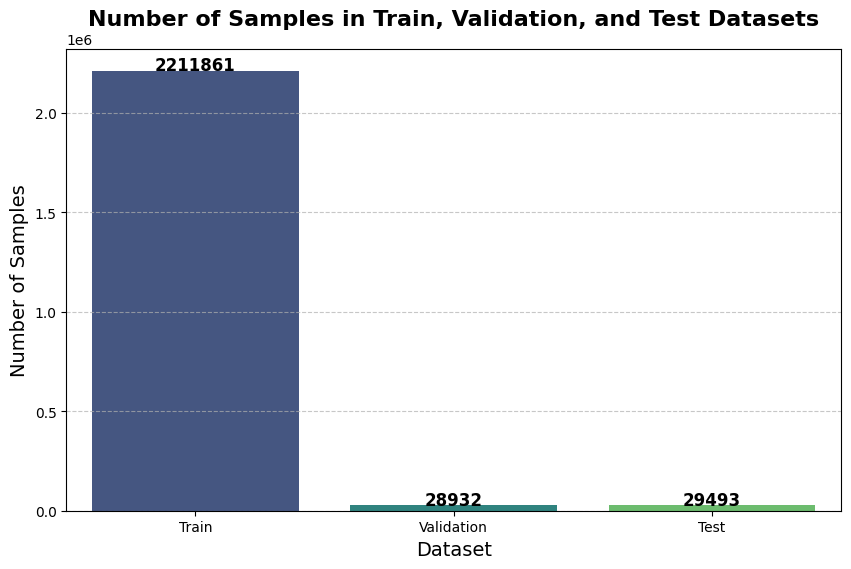

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_lines(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    return lines

def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []
    abstract_id = "Undefined Abstract ID"  # Default placeholder

    for line in input_lines:
        if line.startswith("###"):  # Start of a new abstract
            abstract_id = line.strip()[3:]  # Strip '###' and any leading/trailing whitespace
            abstract_lines = ""
        elif line.isspace():  # End of an abstract
            if abstract_lines:  # Check if there's content
                abstract_line_split = abstract_lines.splitlines()

                for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                    target_text_split = abstract_line.split("\t")
                    if len(target_text_split) < 2:
                        print(f"Skipping malformed line in abstract {abstract_id}: {abstract_line}")
                        continue
                    line_data = {
                        "abstract_id": abstract_id,
                        "target": target_text_split[0],
                        "text": target_text_split[1].lower(),
                        "line_number": abstract_line_number,
                        "total_lines": len(abstract_line_split) - 1
                    }
                    abstract_samples.append(line_data)
        else:
            abstract_lines += line

    return abstract_samples

# Define the directory where your dataset files are located
data_dir = "/content/drive/My Drive/"

# Process each dataset file
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

# Convert lists of dictionaries to dataframes
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

# Concatenate dataframes
full_train_df = pd.concat([train_df, val_df])
data = pd.concat([train_df, val_df, test_df])

# Display the length of each sample set
train_length = len(train_samples)
val_length = len(val_samples)
test_length = len(test_samples)

print(f"Length of train samples: {train_length}")
print(f"Length of validation samples: {val_length}")
print(f"Length of test samples: {test_length}")

# Create a DataFrame for easier plotting
lengths_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'Number of Samples': [train_length, val_length, test_length]
})

# Plotting the lengths
plt.figure(figsize=(10, 6))
sns.barplot(x='Dataset', y='Number of Samples', data=lengths_df, palette='viridis')

# Adding titles and labels
plt.title('Number of Samples in Train, Validation, and Test Datasets', fontsize=16, fontweight='bold')
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)

# Adding grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate the bars with the exact numbers
for index, row in lengths_df.iterrows():
    plt.text(index, row['Number of Samples'] + 100, f"{row['Number of Samples']}", color='black', ha="center", fontsize=12, fontweight='bold')

plt.show()


In [ ]:
data

,abstract_id,target,text,line_number,total_lines
0,24491034,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,24491034,BACKGROUND,this paper describes the design and evaluation...,1,10
2,24491034,METHODS,this study is designed as a randomised control...,2,10
3,24491034,METHODS,the intervention group will participate in the...,3,10
4,24491034,METHODS,the program is based on self-efficacy theory a...,4,10
...,...,...,...,...,...
29488,1922205,RESULTS,bone loss at the median forearm site was signi...,7,11
29489,1922205,RESULTS,breast tenderness occurred in 47 percent of th...,8,11
29490,1922205,RESULTS,vaginal bleeding occurred at some time in 52 p...,9,11
29491,1922205,CONCLUSIONS,in postmenopausal women with low bone density ...,10,11


# Data Exploration



```
# Αυτό έχει τη μορφή κώδικα
```

## N.A check & Uknown

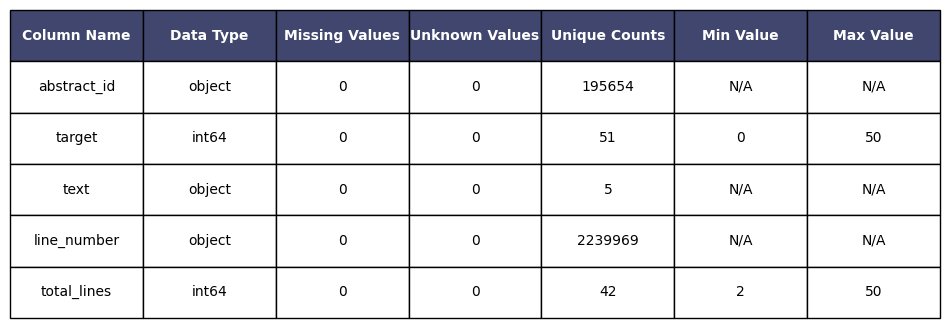

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Calculate statistics
missing_values = data.isnull().sum()
unknown_values = (data == 'Unknown').sum()

# Create a DataFrame to hold the summary
summary_df = pd.DataFrame({
    'Column Name': data.columns,
    'Data Type': data.dtypes,
    'Missing Values': missing_values,
    'Unknown Values': unknown_values,
    'Unique Counts': data.nunique(),
    'Min Value': data.min(numeric_only=True).astype(object),  # Cast to object to avoid FutureWarning
    'Max Value': data.max(numeric_only=True).astype(object)   # Cast to object to avoid FutureWarning
}).reset_index(drop=True)

# Replace NaN with 'N/A' for Min and Max Value columns
summary_df['Min Value'].fillna('N/A', inplace=True)
summary_df['Max Value'].fillna('N/A', inplace=True)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 4))  # Increased the figure width
ax.axis('tight')
ax.axis('off')

# Create the table with wider columns
tbl = Table(ax, bbox=[0, 0, 1, 1])

# Add cells to the table
nrows, ncols = summary_df.shape
width, height = 1.0 / (ncols + 1), 1.0 / (nrows + 1)  # Adjusted column width

# Add header row
for i in range(ncols):
    cell = tbl.add_cell(0, i, width, height, text=summary_df.columns[i], loc='center', facecolor='#40466e', edgecolor='black')
    cell.set_text_props(weight='bold', color='white')  # Set text properties for header

# Add data rows
for row in range(nrows):
    for col in range(ncols):
        tbl.add_cell(row + 1, col, width, height, text=str(summary_df.iat[row, col]), loc='center', facecolor='white', edgecolor='black')

# Add the table to the plot
ax.add_table(tbl)

# Adjust font size for better readability
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

plt.show()


In [ ]:
# # Check for missing values
# print("\nMissing Values:")
# print(data.isnull().sum())

# **DATA DISTRIBUTION**

Data Types:
abstract_id    object
target         object
text           object
line_number     int64
total_lines     int64
dtype: object


<ipython-input-7-708dfb13a2d4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='target', data=data, palette='coolwarm')


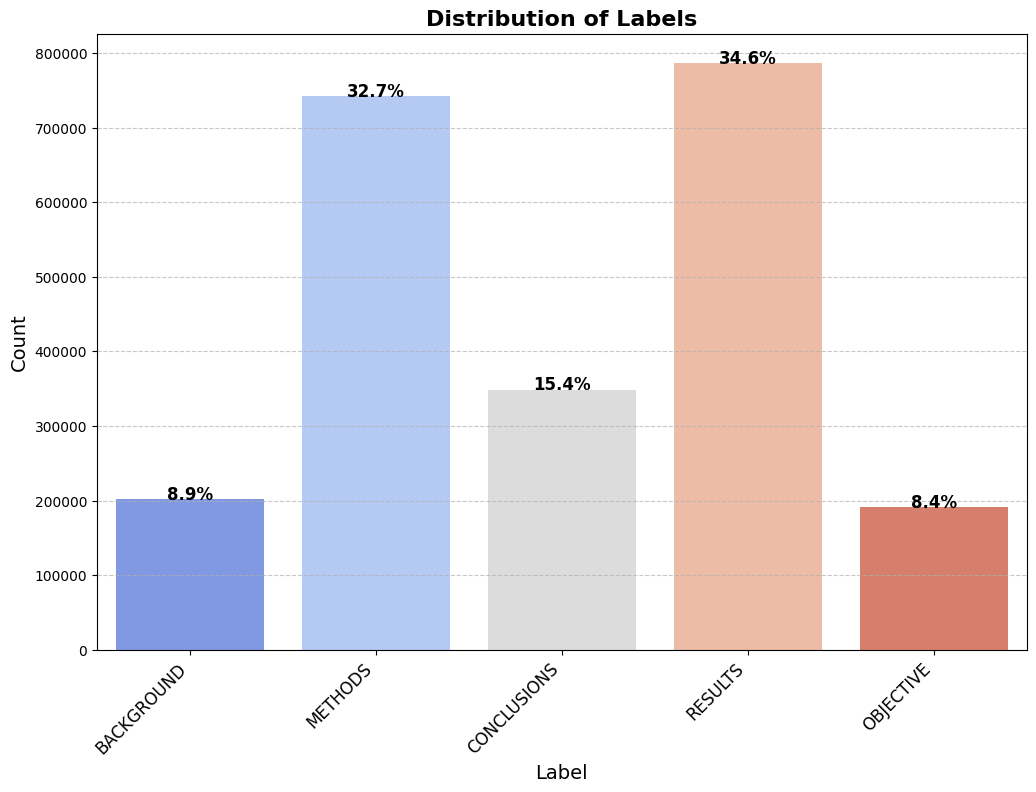


Text Lengths:
count    2.270286e+06
mean     1.505220e+02
std      7.667082e+01
min      2.000000e+00
25%      9.700000e+01
50%      1.380000e+02
75%      1.890000e+02
max      1.813000e+03
Name: text_length, dtype: float64


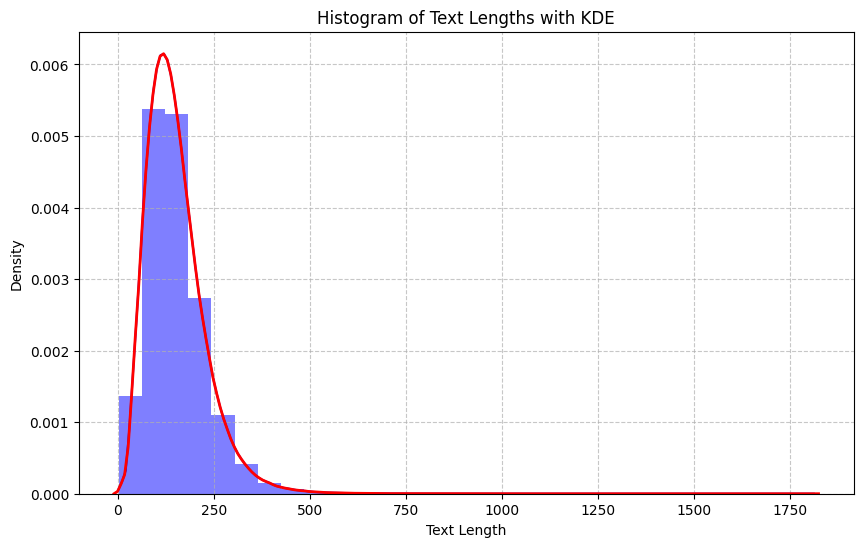

<ipython-input-7-708dfb13a2d4>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='text_length', data=data, palette='Set3')


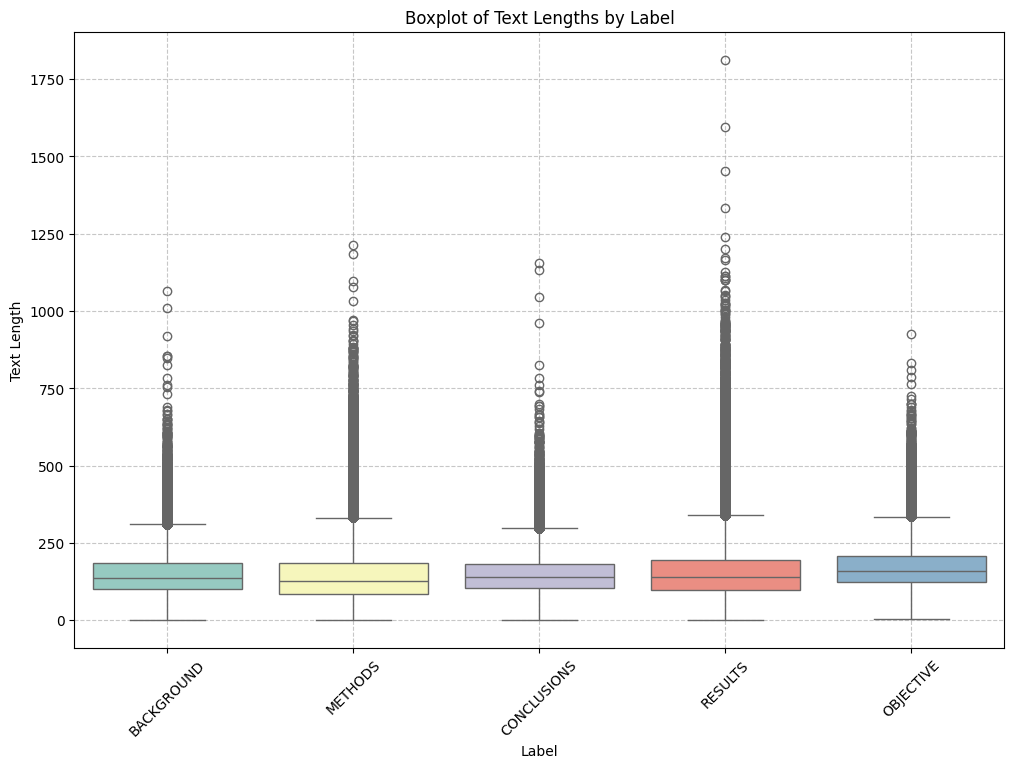

In [ ]:
# Ensure all entries in 'text' are strings
data['text'] = data['text'].astype(str)

# Display data types
print("Data Types:")
print(data.dtypes)

# Display distribution of labels with improved visualization
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='target', data=data, palette='coolwarm')
plt.title('Distribution of Labels', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add percentages on top of the bars
total = len(data)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size=12, ha='center', color='black', weight='bold')

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Calculate text lengths now that we are sure they are strings
data['text_length'] = data['text'].apply(len)
print("\nText Lengths:")
print(data['text_length'].describe())

# Plot histogram of text lengths with KDE and different color
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=30, kde=True, color='blue', stat='density', linewidth=0)
sns.kdeplot(data['text_length'], color='red', lw=2)
plt.title('Histogram of Text Lengths with KDE')
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Boxplot for text lengths by label with improved color scheme
plt.figure(figsize=(12, 8))
sns.boxplot(x='target', y='text_length', data=data, palette='Set3')
plt.title('Boxplot of Text Lengths by Label')
plt.xticks(rotation=45)
plt.xlabel('Label')
plt.ylabel('Text Length')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## IBD Check Dinstinct

Abstracts mentioning IBD terms: 8486
Abstracts mentioning anti-TNF terms: 3033
Abstracts mentioning both IBD and anti-TNF terms: 266


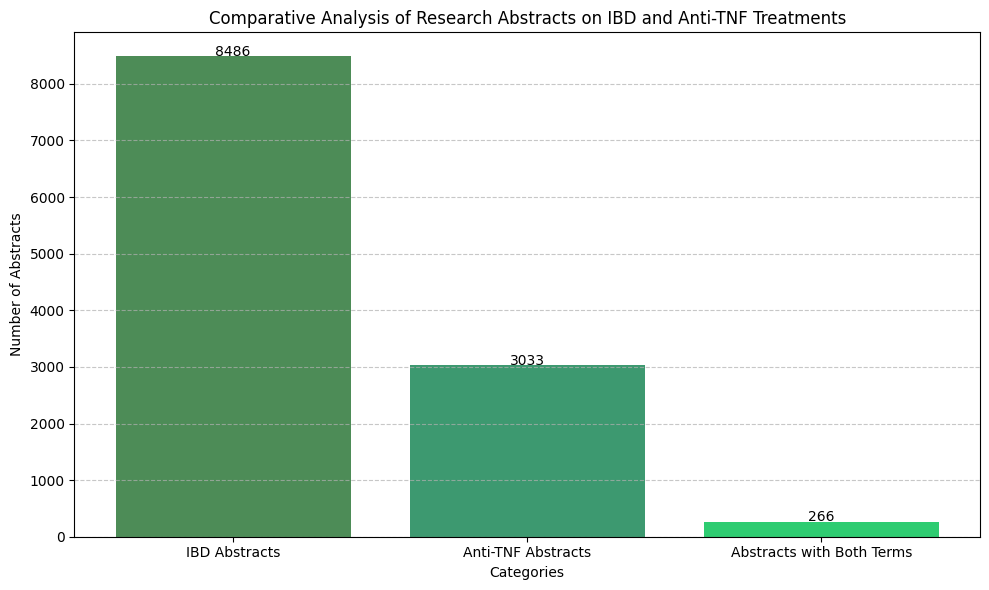

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame with the IBD-related dataset
# data = pd.read_csv('path_to_your_data.csv')

# Terms related to Inflammatory Bowel Disease and Anti-TNF therapies
ibd_terms = ['inflammatory bowel disease', 'IBD', 'Crohn\'s disease', 'Ulcerative colitis', 'colitis', 'ileitis', 'IBS', 'enteritis', 'intestinal microbiota', 'microbiome', 'gastrointestinal tract', 'mucosal inflammation', 'mucosal', 'gut microbiota', 'gut', 'Th1', 'Th2','Th17', 'Regulatory T cells', 'colon', 'small intestine', 'stool', 'rectum', 'pancolitis' ]
anti_tnf_terms = ['anti-TNF', 'infliximab', 'adalimumab', 'certolizumab', 'etanercept', 'golimumab', 'TNF inhibitors', 'Tumor Necrosis Factor', 'anti-tumor necrosis factor', 'TNF blocker', 'humira', 'simponi', 'cimzia', 'remicade', 'anti-TNF monoclonal antibodies', 'TNF receptor', 'anti-cytokine therapy', 'TNF-alpha', 'immunotherapy', 'biosimilar', 'biologic drug', 'autoimmune disease treatment', 'anti-inflammatory biologics' ]

# Filtering data for relevant terms
ibd_data = data[data['text'].str.contains('|'.join(ibd_terms), case=False, na=False)]
anti_tnf_data = data[data['text'].str.contains('|'.join(anti_tnf_terms), case=False, na=False)]

# Getting unique abstract IDs
unique_ibd_ids = set(ibd_data['abstract_id'].drop_duplicates())
unique_anti_tnf_ids = set(anti_tnf_data['abstract_id'].drop_duplicates())

# Identifying overlaps in abstract IDs
both_terms_ids = unique_ibd_ids.intersection(unique_anti_tnf_ids)

# Counting unique abstracts
ibd_count = len(unique_ibd_ids)
anti_tnf_count = len(unique_anti_tnf_ids)
both_terms_count = len(both_terms_ids)

# Printing results
print(f"Abstracts mentioning IBD terms: {ibd_count}")
print(f"Abstracts mentioning anti-TNF terms: {anti_tnf_count}")
print(f"Abstracts mentioning both IBD and anti-TNF terms: {both_terms_count}")

# Visualization setup
plt.figure(figsize=(10, 6))
colors = ['#4D8C57', '#3D9970', '#2ECC71']  # Fresh green shades
bar_labels = ['IBD Abstracts', 'Anti-TNF Abstracts', 'Abstracts with Both Terms']
counts = [ibd_count, anti_tnf_count, both_terms_count]

# Creating the bar plot
plt.bar(bar_labels, counts, color=colors)
plt.title('Comparative Analysis of Research Abstracts on IBD and Anti-TNF Treatments')
plt.xlabel('Categories')
plt.ylabel('Number of Abstracts')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding text labels for counts on bars
for i, count in enumerate(counts):
    plt.text(i, count + 5, str(count), ha='center', color='black')

plt.tight_layout()
plt.show()


# **PREPROCESSING**

In [ ]:
train_samples[:14]

[{'abstract_id': '24491034',
  'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_lines': 10},
 {'abstract_id': '24491034',
  'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'line_number': 1,
  'total_lines': 10},
 {'abstract_id': '24491034',
  'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_lines': 10},
 {'abstract_id': '24491034',
  'target': 'METHODS',
  'text': "the intervention group will participate in th

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,abstract_id,target,text,line_number,total_lines
0,24491034,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,24491034,BACKGROUND,this paper describes the design and evaluation...,1,10
2,24491034,METHODS,this study is designed as a randomised control...,2,10
3,24491034,METHODS,the intervention group will participate in the...,3,10
4,24491034,METHODS,the program is based on self-efficacy theory a...,4,10
5,24491034,METHODS,participants will access the program for a min...,5,10
6,24491034,METHODS,primary outcomes are domain specific self-effi...,6,10
7,24491034,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,24491034,METHODS,"data collection will take place at baseline , ...",8,10
9,24491034,CONCLUSIONS,results of the positive outlook study will pro...,9,10


In [ ]:
train_df.target.value_counts()

,count
target,
RESULTS,766271
METHODS,722586
CONCLUSIONS,339714
BACKGROUND,196689
OBJECTIVE,186601


<ipython-input-12-db00f616681b>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


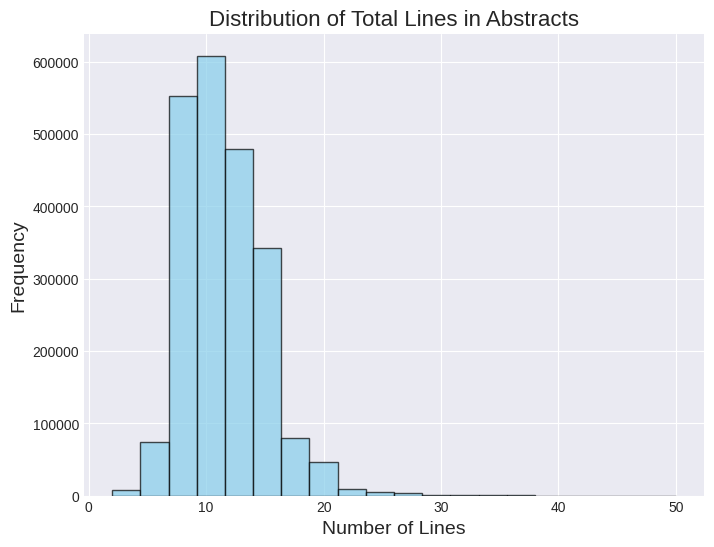

In [ ]:
import matplotlib.pyplot as plt

# Set the style for the plot
plt.style.use('seaborn-darkgrid')

# Create the histogram with nicer colors and additional formatting
plt.figure(figsize=(8, 6))
plt.hist(train_df['total_lines'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Total Lines in Abstracts', fontsize=16)
plt.xlabel('Number of Lines', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Show the plot
plt.show()


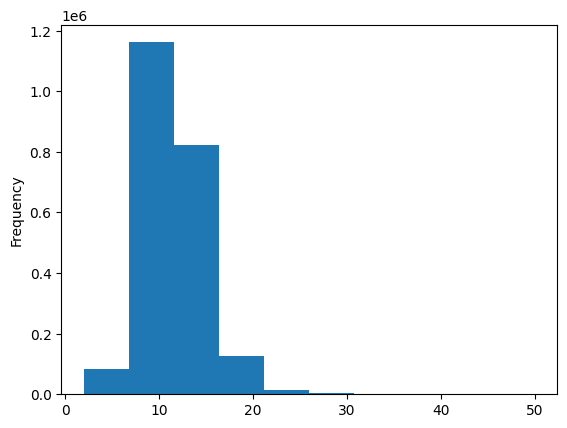

In [ ]:
# train_df.total_lines.plot.hist();

In [ ]:
# text lines to list
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
train_sentences[:10]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of 90 minutes per week over seven weeks .',
 'primary outcomes are domain s

In [ ]:
# one hot-encoded labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
# label encoded label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# **MODELS**

# **MODEL 1 SVM** METHOD

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Model Parameters: {'clf__C': 10, 'clf__gamma': 0.01, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Validation Accuracy: 0.7244466550609301
Validation Precision: 0.7506793839334717
Validation Recall: 0.7244466550609301
              precision    recall  f1-score   support

  BACKGROUND       0.46      0.61      0.53       533
 CONCLUSIONS       0.62      0.74      0.67       764
     METHODS       0.83      0.86      0.85      1028
   OBJECTIVE       0.74      0.58      0.65       596
     RESULTS       0.92      0.72      0.80      1100

    accuracy                           0.72      4021
   macro avg       0.71      0.70      0.70      4021
weighted avg       0.75      0.72      0.73      4021

Test Accuracy: 0.7261875155433971
Test Precision: 0.7555916429871333
Test Recall: 0.7261875155433971
              precision    recall  f1-score   support

  BACKGROUND       0.49      0.67      0.57       504
 CONCLUSIONS       0.59      0.73      0.65       696
     METHO

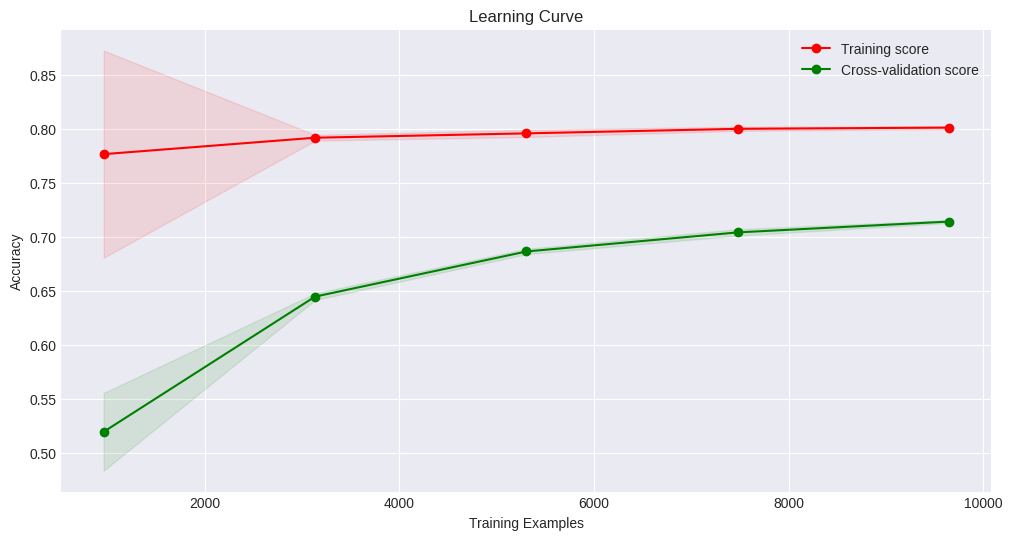

In [ ]:
#  train_df, val_df, test_df are the DataFrames loaded from the preprocessing output
# Combine train_df and val_df for full training dataset
full_train_df = data

# Preprocessing function to prepare text data
def preprocess_text(texts):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    preprocessed_texts = []
    for doc in texts:
        words = [lemmatizer.lemmatize(word.lower()) for word in doc.split() if word.lower() not in stop_words]
        preprocessed_texts.append(" ".join(words))
    return preprocessed_texts

# Keywords and pattern compilation for data filtering
ibd_terms = [
    'inflammatory bowel disease', 'IBD', 'Crohn\'s disease', 'Ulcerative colitis',
    'colitis', 'ileitis', 'IBS', 'enteritis', 'intestinal microbiota',
    'microbiome', 'gastrointestinal tract', 'mucosal inflammation',
    'mucosal', 'gut microbiota', 'gut', 'Th1', 'Th2', 'Th17',
    'Regulatory T cells', 'colon', 'small intestine', 'stool', 'rectum',
    'pancolitis'
]

anti_tnf_terms = [
    'anti-TNF', 'infliximab', 'adalimumab', 'certolizumab', 'etanercept',
    'golimumab', 'TNF inhibitors', 'Tumor Necrosis Factor',
    'anti-tumor necrosis factor', 'TNF blocker', 'humira', 'simponi',
    'cimzia', 'remicade', 'anti-TNF monoclonal antibodies', 'TNF receptor',
    'anti-cytokine therapy', 'TNF-alpha', 'immunotherapy', 'biosimilar',
    'biologic drug', 'autoimmune disease treatment', 'anti-inflammatory biologics'
]

keywords = ibd_terms + anti_tnf_terms
pattern = r'\b(?:' + '|'.join(keywords) + r')\b'

# Filter data based on keywords
full_train_df_filtered = full_train_df[full_train_df['text'].str.contains(pattern, flags=re.IGNORECASE, na=False)]

X = preprocess_text(full_train_df_filtered['text'])
y = full_train_df_filtered['target']

# Split the data into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2 of the original data

# SVM Pipeline setup with class weighting to handle imbalance
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(random_state=42, probability=True, class_weight='balanced'))  # Added class_weight='balanced'
])

# Correctly defined param_grid
param_grid = {
    'clf__C': [0.1, 10],
    'clf__gamma': [0.01],
    'tfidf__max_features': [10000],
    'tfidf__ngram_range': [(1, 2)]
}

# Grid search with custom scorers, now using the validation set
scorers = {
    'precision_score': make_scorer(precision_score, average='weighted'),
    'recall_score': make_scorer(recall_score, average='weighted'),
    'accuracy_score': make_scorer(accuracy_score)
}

grid_search = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=param_grid, scoring=scorers, refit='accuracy_score')
grid_search.fit(X_train, y_train)  # Fit on the training set, validation set is used internally during cross-validation

# Best model evaluation on the validation set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')

# Display validation results
print("Best Model Parameters:", grid_search.best_params_)
print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print(classification_report(y_val, y_val_pred))

# Final evaluation on the test set
y_test_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')

# Display test results
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print(classification_report(y_test, y_test_pred))

# Learning curve visualization using the training set and cross-validation
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="g", alpha=0.1)
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()


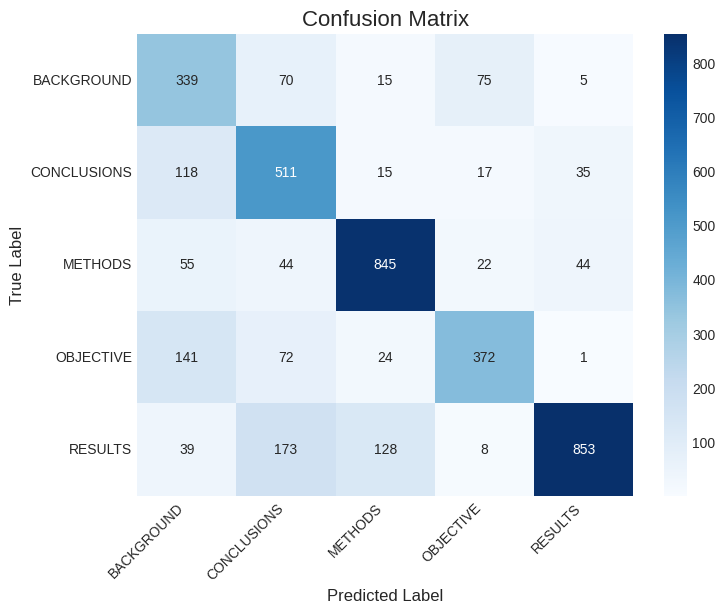

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Fix the confusion matrix plot with better formatting
plt.figure(figsize=(8, 6))  # Set a better figure size for clarity
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Titles and labels
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Rotate the x-tick labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()


# MODEL 2 Preprocessing

In [ ]:
pip install tensorflow


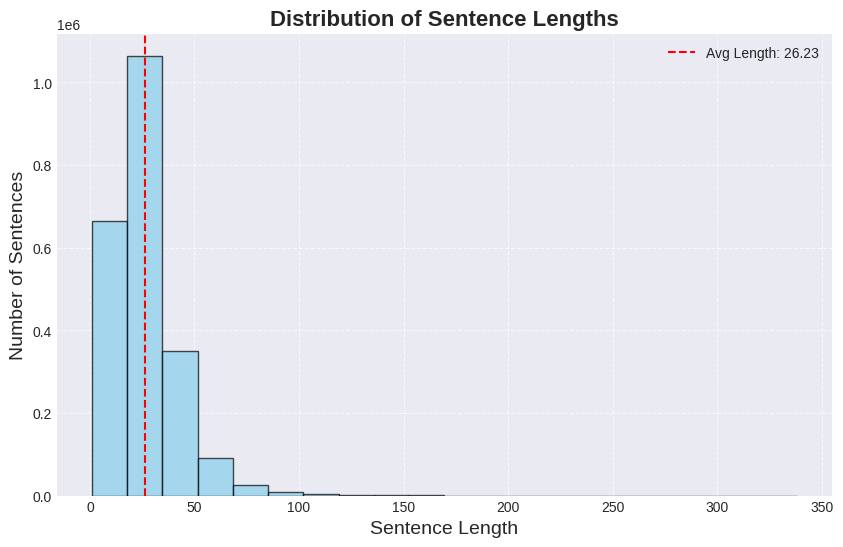

95th percentile of sentence length: 54
Text:
after brain stem death ( bsd ) , a low t ( 3 ) state is common , and t ( 3 ) supplementation has been advocated to improve heart function and yield for transplantation .

Length of text: 36

Vectorized text:
[[   20   996  3961   436 46704     8   229   420    45   966    22   418
      4   420    45   504   148   163  7660     6   293   238   167     4
   3536    12  1435     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]]
Number of words in vocabulary: 68000
Most common words in the vocabulary: ['', '[UNK]', 'the', 'of', 'and']
Least common words in the vocabulary: ['postspace', 'postscan', 'postsalbutamol', 'postpractice', 'postphlebitic']
Sentence before vectorization:
after brain stem death ( bsd ) , a low t ( 3 ) state is common , and t ( 3 ) supplementation has been advocated to improve heart function and yield for trans

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers  # Importing layers for the embedding
from tensorflow.keras.layers import TextVectorization
import random

# Assuming 'train_sentences' holds your dataset of sentences
# Replace 'train_sentences' with your actual dataset
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)

# Improved histogram visualization
plt.figure(figsize=(10, 6))
plt.hist(sent_lens, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Sentence Lengths', fontsize=16, fontweight='bold')
plt.xlabel('Sentence Length', fontsize=14)
plt.ylabel('Number of Sentences', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Adding annotation for average sentence length
plt.axvline(avg_sent_len, color='red', linestyle='dashed', linewidth=1.5, label=f'Avg Length: {avg_sent_len:.2f}')
plt.legend()

plt.show()

# Calculating the 95th percentile of sentence lengths
output_seq_len = int(np.percentile(sent_lens, 95))
print(f"95th percentile of sentence length: {output_seq_len}")

# Text Vectorizer
max_tokens = 68000  # based on the paper

text_vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_seq_len)
text_vectorizer.adapt(train_sentences)

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(vocab)}")
print(f"Most common words in the vocabulary: {vocab[:5]}")
print(f"Least common words in the vocabulary: {vocab[-5:]}")

# Create a token embedding layer
token_embed = layers.Embedding(input_dim=len(vocab), output_dim=128, mask_zero=True, name="token_embedding")

print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")


# **MODEL 2: Feature extraction with sentence embeddings (USE) **

Number of unique articles after filtering: 8014
Epoch 1/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5537 - loss: 1.2655 - val_accuracy: 0.7150 - val_loss: 0.7676
Epoch 2/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6980 - loss: 0.8521 - val_accuracy: 0.7222 - val_loss: 0.7288
Epoch 3/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7179 - loss: 0.8079 - val_accuracy: 0.7346 - val_loss: 0.7075
Epoch 4/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7248 - loss: 0.7700 - val_accuracy: 0.7354 - val_loss: 0.6976
Epoch 5/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7331 - loss: 0.7502 - val_accuracy: 0.7369 - val_loss: 0.6902
Epoch 6/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7409 - loss: 0.7313 - val_accuracy: 0.7374 - val_loss: 0.6855
Epoch 7/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7449 - loss: 0.7209 - val_accuracy: 0.7361 - val_loss: 0.6804
Epoch 8/10
377/377 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/s

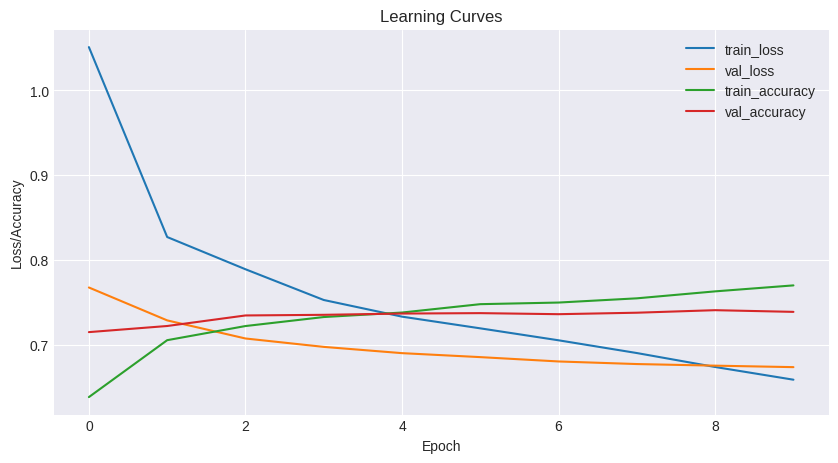

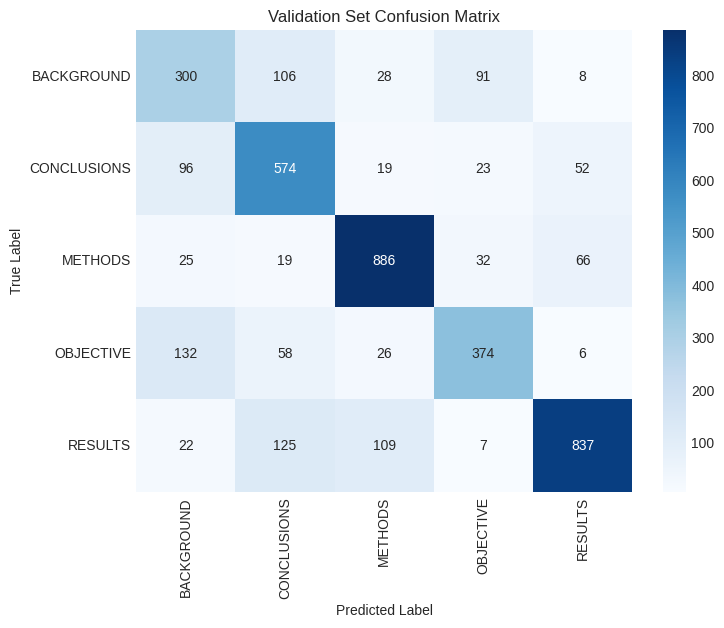

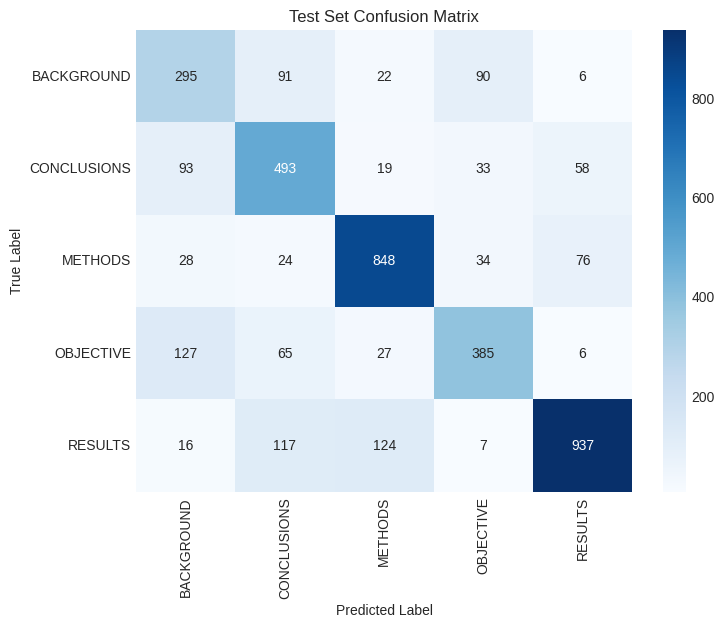

Validation Results: [0.6737203598022461, 0.7388709187507629]
Test Results: [0.682459831237793, 0.735637903213501]


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Updated Keywords
ibd_terms = [
    'inflammatory bowel disease', 'IBD', 'Crohn\'s disease', 'Ulcerative colitis',
    'colitis', 'ileitis', 'IBS', 'enteritis', 'intestinal microbiota',
    'microbiome', 'gastrointestinal tract', 'mucosal inflammation',
    'mucosal', 'gut microbiota', 'gut', 'Th1', 'Th2', 'Th17',
    'Regulatory T cells', 'colon', 'small intestine', 'stool', 'rectum',
    'pancolitis'
]

anti_tnf_terms = [
    'anti-TNF', 'infliximab', 'adalimumab', 'certolizumab', 'etanercept',
    'golimumab', 'TNF inhibitors', 'Tumor Necrosis Factor',
    'anti-tumor necrosis factor', 'TNF blocker', 'humira', 'simponi',
    'cimzia', 'remicade', 'anti-TNF monoclonal antibodies', 'TNF receptor',
    'anti-cytokine therapy', 'TNF-alpha', 'immunotherapy', 'biosimilar',
    'biologic drug', 'autoimmune disease treatment', 'anti-inflammatory biologics'
]

# Pattern compilation
keywords = ibd_terms + anti_tnf_terms
pattern = r'\b(?:' + '|'.join(keywords) + r')\b'

# Assuming full_train_df is your dataset
full_train_df = full_train_df[full_train_df['text'].str.contains(pattern, flags=re.IGNORECASE, na=False)]

# Print the number of unique articles after filtering
unique_article_count = full_train_df['abstract_id'].nunique()
print("Number of unique articles after filtering:", unique_article_count)

# Splitting into features (text) and labels
X = full_train_df['text'].values
y = full_train_df['target'].values

# Label encoding for string labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting into train, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

# Convert labels to one-hot encoding
num_classes = len(set(y_train))
train_labels_one_hot = tf.one_hot(y_train, depth=num_classes)
val_labels_one_hot = tf.one_hot(y_val, depth=num_classes)
test_labels_one_hot = tf.one_hot(y_test, depth=num_classes)

# Create datasets for training, validation, and testing
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, test_labels_one_hot))

# Shuffle, batch, and cache the training dataset
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Calculate class weights to handle imbalanced data
class_weights = {i: weight for i, weight in enumerate(len(y_train) / (num_classes * np.bincount(y_train)))}

# Wrapping Universal Sentence Encoder inside a Lambda layer and providing output shape
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

def universal_sentence_encoder_layer(x):
    return tf_hub_embedding_layer(x)

# Model setup with dropout layer
inputs = layers.Input(shape=(), dtype=tf.string)
pretrained_embedding = layers.Lambda(universal_sentence_encoder_layer, output_shape=(512,))(inputs)  # Setting output shape explicitly
x = layers.Dense(128, activation="relu")(pretrained_embedding)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Set the best hyperparameters
best_num_epochs = 10
best_batch_size = 32
best_learning_rate = 0.001

# Compile the model with the best learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
              metrics=["accuracy"])

# Callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model with class weights
history = model.fit(train_dataset, epochs=best_num_epochs, batch_size=best_batch_size,
                    validation_data=val_dataset, class_weight=class_weights,
                    callbacks=[early_stopping])

# Validation and test set evaluation
val_results = model.evaluate(val_dataset)
test_results = model.evaluate(test_dataset)

# Generate classification reports and confusion matrices
def generate_report_and_confusion_matrix(dataset, one_hot_encoded):
    pred_prob = model.predict(dataset)
    pred_labels = np.argmax(pred_prob, axis=1)
    true_labels = np.argmax(one_hot_encoded.numpy(), axis=1)

    report = classification_report(true_labels, pred_labels, target_names=label_encoder.classes_)
    conf_matrix = confusion_matrix(true_labels, pred_labels)

    return report, conf_matrix

val_report, val_conf_matrix = generate_report_and_confusion_matrix(val_dataset, val_labels_one_hot)
test_report, test_conf_matrix = generate_report_and_confusion_matrix(test_dataset, test_labels_one_hot)

# Display validation results as a table
print("\nValidation Classification Report:")
print(val_report)

# Display test results as a table
print("\nTest Classification Report:")
print(test_report)

# Plotting the learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(history)

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Display evaluation results
print(f"Validation Results: {val_results}")
print(f"Test Results: {test_results}")


#MODEL 3 Model 3: Conv1D with Character Embeddings

Number of unique articles after filtering: 8014


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_2                 │ (None, 290)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 290, 128)            │           8,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 290, 64)             │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,821 (229.77 KB)

 Trainable params: 58,821 (229.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
69121/69121 ━━━━━━━━━━━━━━━━━━━━ 1571s 23ms/step - accuracy: 0.7214 - loss: 0.8253 - val_accuracy: 0.7767 - val_loss: 0.5966
Epoch 2/10
69121/69121 ━━━━━━━━━━━━━━━━━━━━ 1516s 22ms/step - accuracy: 0.7796 - loss: 0.6843 - val_accuracy: 0.7863 - val_loss: 0.5710
Epoch 3/10
69121/69121 ━━━━━━━━━━━━━━━━━━━━ 1461s 21ms/step - accuracy: 0.7856 - loss: 0.6682 - val_accuracy: 0.7882 - val_loss: 0.5612
Epoch 4/10
69121/69121 ━━━━━━━━━━━━━━━━━━━━ 1388s 20ms/step - accuracy: 0.7886 - loss: 0.6605 - val_accuracy: 0.7929 - val_loss: 0.5477
Epoch 5/10
69121/69121 ━━━━━━━━━━━━━━━━━━━━ 1381s 20ms/step - accuracy: 0.7904 - loss: 0.6558 - val_accuracy: 0.7917 - val_loss: 0.5516
Epoch 6/10
69121/69121 ━━━━━━━━━━━━━━━━━━━━ 1460s 21ms/step - accuracy: 0.7914 - loss: 0.6528 - val_accuracy: 0.7933 - val_loss: 0.5470
Epoch 7/10
69121/69121 ━━━━━━━━━━━━━━━━━━━━ 1455s 21ms/step - accuracy: 0.7920 - loss: 0.6505 - val_accuracy: 0.7937 - val_loss: 0.5473
Epoch 8/10
69121/69121 ━━━━━━━━━━━━━━━━━━━━ 1491

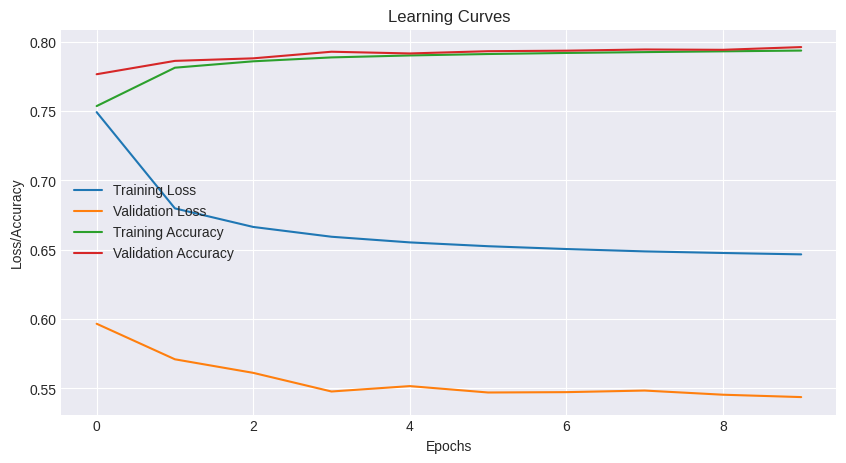

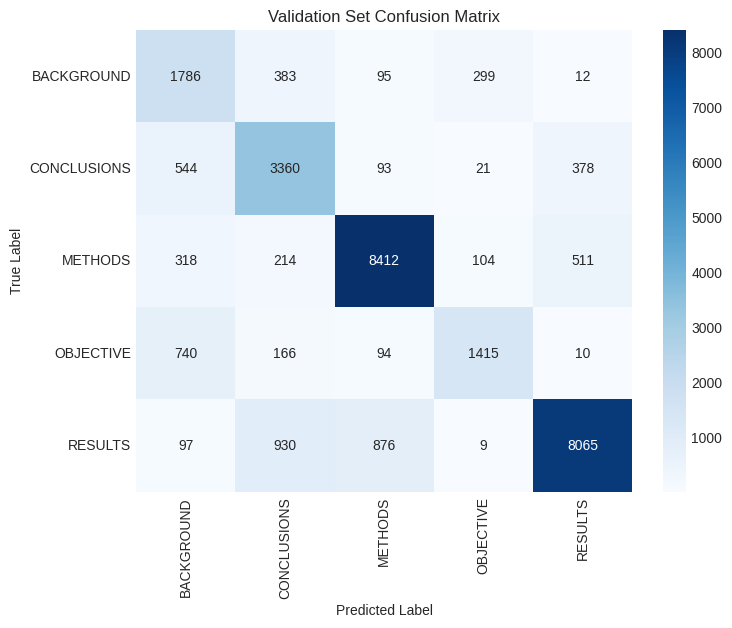

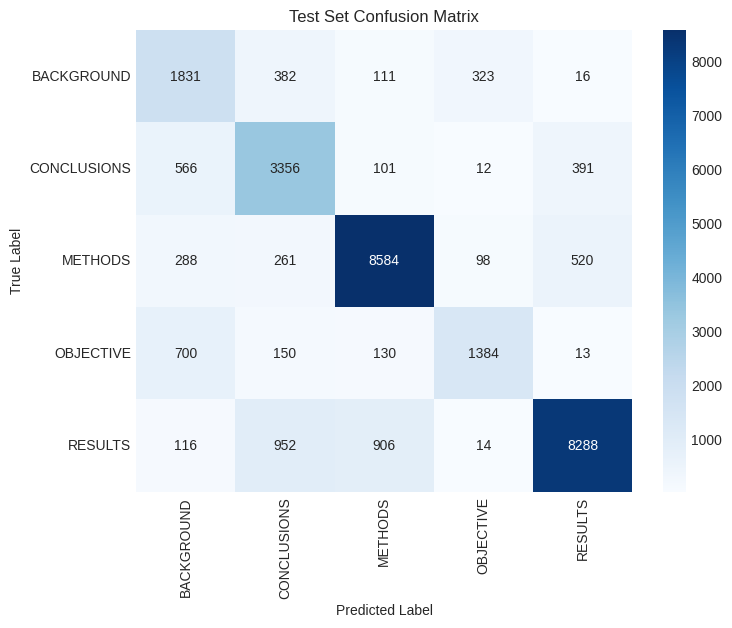

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Assuming you have already loaded your dataset (train_df, val_df, test_df)
# train_df, val_df, and test_df are DataFrames with 'text' and 'target' columns
# Assuming full_train_df is your dataset
full_train_df = full_train_df[full_train_df['text'].str.contains(pattern, flags=re.IGNORECASE, na=False)]


# Updated Keywords
ibd_terms = [
    'inflammatory bowel disease', 'IBD', 'Crohn\'s disease', 'Ulcerative colitis',
    'colitis', 'ileitis', 'IBS', 'enteritis', 'intestinal microbiota',
    'microbiome', 'gastrointestinal tract', 'mucosal inflammation',
    'mucosal', 'gut microbiota', 'gut', 'Th1', 'Th2', 'Th17',
    'Regulatory T cells', 'colon', 'small intestine', 'stool', 'rectum',
    'pancolitis'
]

anti_tnf_terms = [
    'anti-TNF', 'infliximab', 'adalimumab', 'certolizumab', 'etanercept',
    'golimumab', 'TNF inhibitors', 'Tumor Necrosis Factor',
    'anti-tumor necrosis factor', 'TNF blocker', 'humira', 'simponi',
    'cimzia', 'remicade', 'anti-TNF monoclonal antibodies', 'TNF receptor',
    'anti-cytokine therapy', 'TNF-alpha', 'immunotherapy', 'biosimilar',
    'biologic drug', 'autoimmune disease treatment', 'anti-inflammatory biologics'
]

# Pattern compilation
keywords = ibd_terms + anti_tnf_terms
pattern = r'\b(?:' + '|'.join(keywords) + r')\b'

# Assuming full_train_df is your dataset
full_train_df = full_train_df[full_train_df['text'].str.contains(pattern, flags=re.IGNORECASE, na=False)]

# Print the number of unique articles after filtering
unique_article_count = full_train_df['abstract_id'].nunique()
print("Number of unique articles after filtering:", unique_article_count)

# Split text data into characters for character embedding
def split_chars(text):
    return " ".join(list(text))

# Apply the split_chars function to your data
train_chars = train_df['text'].apply(split_chars).tolist()
val_chars = val_df['text'].apply(split_chars).tolist()
test_chars = test_df['text'].apply(split_chars).tolist()

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].values)
val_labels_encoded = label_encoder.transform(val_df['target'].values)
test_labels_encoded = label_encoder.transform(test_df['target'].values)

num_classes = len(label_encoder.classes_)

# Convert labels to one-hot encoding
train_labels_one_hot = tf.one_hot(train_labels_encoded, depth=num_classes)
val_labels_one_hot = tf.one_hot(val_labels_encoded, depth=num_classes)
test_labels_one_hot = tf.one_hot(test_labels_encoded, depth=num_classes)

# Create character-level vectorizer and embedding
alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '
max_len = 290  # Max character length, adjust based on dataset

# TextVectorization layer for characters
char_vectorizer = layers.TextVectorization(max_tokens=len(alphabet), output_sequence_length=max_len, standardize="lower_and_strip_punctuation")
char_vectorizer.adapt(train_chars)

# Create character embedding layer
char_embed = layers.Embedding(input_dim=len(alphabet), output_dim=128)

# Build Model 3: Conv1D with Character Embeddings
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)

# Conv1D layer with character embeddings
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = models.Model(inputs=inputs, outputs=outputs)

# Compile the model with hyperparameter tuning
best_learning_rate = 0.0005
model_3.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate), metrics=["accuracy"])

# Calculate class weights for imbalanced classes
class_weights = {i: len(train_labels_encoded) / (num_classes * np.bincount(train_labels_encoded)[i]) for i in range(num_classes)}

# Print the model summary
model_3.summary()

# Prepare datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model with early stopping and class weights
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model_3.fit(train_dataset, epochs=10, validation_data=val_dataset, class_weight=class_weights, callbacks=[early_stopping])

# Evaluate on validation and test sets
val_results = model_3.evaluate(val_dataset)
test_results = model_3.evaluate(test_dataset)
print(f"Validation Results: {val_results}")
print(f"Test Results: {test_results}")

# Function to generate classification reports and confusion matrices
def generate_report_and_confusion_matrix(dataset, one_hot_encoded, labels):
    pred_prob = model_3.predict(dataset)
    pred_labels = np.argmax(pred_prob, axis=1)
    true_labels = np.argmax(one_hot_encoded.numpy(), axis=1)

    report = classification_report(true_labels, pred_labels, target_names=labels)
    conf_matrix = confusion_matrix(true_labels, pred_labels)

    return report, conf_matrix

# Generate and display classification reports and confusion matrices
val_report, val_conf_matrix = generate_report_and_confusion_matrix(val_dataset, val_labels_one_hot, label_encoder.classes_)
test_report, test_conf_matrix = generate_report_and_confusion_matrix(test_dataset, test_labels_one_hot, label_encoder.classes_)

print("\nValidation Classification Report:")
print(val_report)

print("\nTest Classification Report:")
print(test_report)

# Plot learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(history)

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
!pip install scikit-learn
!pip install tensorflow


#MODEL 4 Hydrid

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_9      │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 512)            │              0 │ token_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 290, 128)       │          8,832 │ text_vectorization_9[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 128)            │         65,664 │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 128)            │         98,816 │ embedding_3[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 256)            │              0 │ dense_18[0][0],        │
│ (Concatenate)             │                        │                │ bidirectional_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 256)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 256)            │         65,792 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 256)            │              0 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 5)              │          1,285 │ dropout_13[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 240,389 (939.02 KB)

 Trainable params: 240,389 (939.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 41s 151ms/step - accuracy: 0.4362 - loss: 1.3219 - val_accuracy: 0.6845 - val_loss: 0.8112
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - accuracy: 0.6673 - loss: 0.8372 - val_accuracy: 0.7232 - val_loss: 0.7525
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 31s 140ms/step - accuracy: 0.6975 - loss: 0.7639 - val_accuracy: 0.7258 - val_loss: 0.7283
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - accuracy: 0.7256 - loss: 0.7123 - val_accuracy: 0.7296 - val_loss: 0.7143
Epoch 5/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 31s 140ms/step - accuracy: 0.7237 - loss: 0.6943 - val_accuracy: 0.7283 - val_loss: 0.7192
Epoch 6/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 31s 140ms/step - accuracy: 0.7401 - loss: 0.6612 - val_accuracy: 0.7338 - val_loss: 0.7094
Epoch 7/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step - accuracy: 0.7473 - loss: 0.6331 - val_accuracy: 0.7377 - val_loss: 0.7022
Epoch 8/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - accuracy: 0.7539 - loss: 0

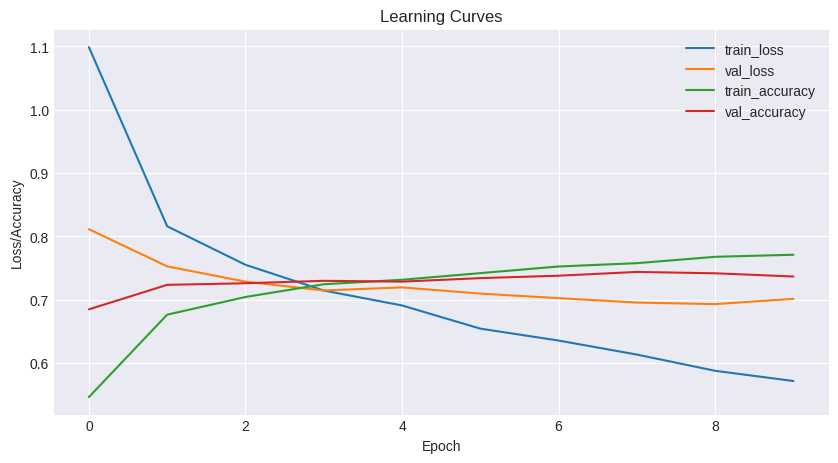

74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step

Test Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.54      0.51      0.52       356
 CONCLUSIONS       0.63      0.71      0.67       457
     METHODS       0.83      0.87      0.85       608
   OBJECTIVE       0.74      0.59      0.65       388
     RESULTS       0.81      0.82      0.81       543

    accuracy                           0.73      2352
   macro avg       0.71      0.70      0.70      2352
weighted avg       0.73      0.73      0.72      2352



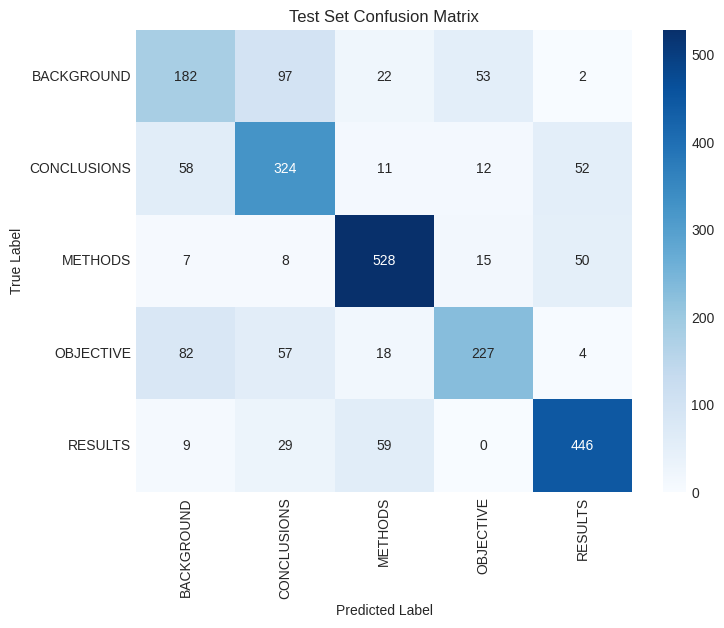

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns

# Predefined keywords for IBD-related terms
ibd_terms = [
    'inflammatory bowel disease', 'IBD', 'Crohn\'s disease', 'Ulcerative colitis',
    'colitis', 'ileitis', 'IBS', 'enteritis', 'intestinal microbiota',
    'microbiome', 'gastrointestinal tract', 'mucosal inflammation',
    'mucosal', 'gut microbiota', 'gut', 'Th1', 'Th2', 'Th17',
    'Regulatory T cells', 'colon', 'small intestine', 'stool', 'rectum',
    'pancolitis'
]

# Filtering your dataset using keywords
pattern = r'\b(?:' + '|'.join(ibd_terms) + r')\b'
full_train_df = full_train_df[full_train_df['text'].str.contains(pattern, flags=re.IGNORECASE, na=False)]

# Split your data (train, validation, test)
X = full_train_df['text'].values
y = full_train_df['target'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

# Convert labels to one-hot encoding
num_classes = len(set(y_train))
train_labels_one_hot = tf.one_hot(y_train, depth=num_classes)
val_labels_one_hot = tf.one_hot(y_val, depth=num_classes)
test_labels_one_hot = tf.one_hot(y_test, depth=num_classes)

# Token Embedding: Use Universal Sentence Encoder
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

# Wrap the Universal Sentence Encoder with a Lambda layer to avoid the KerasTensor issue
def universal_sentence_encoder(inputs):
    return tf_hub_embedding_layer(inputs)

# Character Embedding Setup
alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '
max_len = 290  # Adjust character sequence length based on your dataset

# Character vectorization and embedding
char_vectorizer = layers.TextVectorization(max_tokens=len(alphabet), output_sequence_length=max_len)
char_vectorizer.adapt([split_chars(sentence) for sentence in X_train])

char_embed = layers.Embedding(input_dim=len(alphabet), output_dim=128)

# Model Setup: Token + Character Hybrid Embedding
# 1. Token inputs and embedding
token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = layers.Lambda(universal_sentence_encoder, output_shape=(512,))(token_inputs)  # Use Lambda layer with explicit output shape
token_output = layers.Dense(128, activation="relu")(token_embeddings)

# 2. Character inputs and embedding
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(64))(char_embeddings)

# 3. Combine token and character embeddings into a hybrid model
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_output, char_bi_lstm])
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(256, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)

# 4. Output layer
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Compile the hybrid model
model_4 = models.Model(inputs=[token_inputs, char_inputs], outputs=output_layer)
model_4.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

# Print model summary
model_4.summary()

# Prepare the datasets with token and char inputs
train_char_token_dataset = tf.data.Dataset.from_tensor_slices(((X_train, [split_chars(sent) for sent in X_train]), train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = tf.data.Dataset.from_tensor_slices(((X_val, [split_chars(sent) for sent in X_val]), val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = tf.data.Dataset.from_tensor_slices(((X_test, [split_chars(sent) for sent in X_test]), test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model
history = model_4.fit(train_char_token_dataset, epochs=10, validation_data=val_char_token_dataset)

# Evaluate the model on the test set
test_results = model_4.evaluate(test_char_token_dataset)
print(f"Test Results: {test_results}")

# Plotting the learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(history)

# Generate predictions and confusion matrix
def generate_report_and_confusion_matrix(dataset, one_hot_labels):
    pred_prob = model_4.predict(dataset)
    pred_labels = np.argmax(pred_prob, axis=1)
    true_labels = np.argmax(one_hot_labels.numpy(), axis=1)

    report = classification_report(true_labels, pred_labels, target_names=label_encoder.classes_)
    conf_matrix = confusion_matrix(true_labels, pred_labels)

    return report, conf_matrix

test_report, test_conf_matrix = generate_report_and_confusion_matrix(test_char_token_dataset, test_labels_one_hot)

print("\nTest Classification Report:")
print(test_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
